###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from micrograd.engine import Value
from micrograd.nn import MLP


In [3]:
np.random.seed(1337)
random.seed(1337)


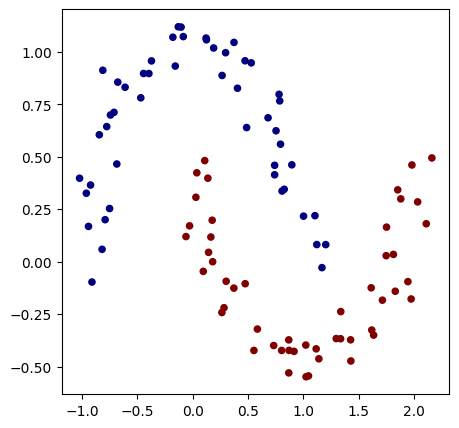

In [4]:
# make up a dataset

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')


In [5]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))


MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [6]:
# set batch_size to <= 0 for no batching
batch_size = 50
steps = 200

#batch_size = 0
#steps = 100

# inline DataLoader :)
if batch_size > 0:
    # prepare batches.
    # They will be filled with actual values in the loss function.
    Xb = [[Value(0.0), Value(0.0)] for _ in range(batch_size)]
    yb = [Value(0.0) for _ in range(batch_size)]
else:
    Xb = [list(map(Value, xrow)) for xrow in X]
    yb = [Value(yi) for yi in y]

# forward the model to get scores
scores = [model(xi) for xi in Xb]

# svm "max-margin" loss
losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
data_loss = sum(losses) * (1.0 / len(losses))
# L2 regularization
alpha = 1e-4
reg_loss = alpha * sum((p*p for p in model.parameters()))
total_loss = data_loss + reg_loss

# loss function
def loss(k, batch_size):
    if batch_size > 0:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        for i, xi in enumerate(X[ri]):
            Xb[i][0].assign(xi[0])
            Xb[i][1].assign(xi[1])

        for i, yi in enumerate(y[ri]):
            yb[i].assign(yi)

    total_loss.refresh(k)

    # also get accuracy
    accuracy = [(yi.data > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss(0, batch_size)
print(total_loss, acc)


Value(data=1.0095926564315, grad=0.0) 0.56


In [7]:
# optimization
for k in range(steps):
    
    # forward
    total_loss, acc = loss(k, batch_size)
    
    # backward
    # this is done implicitely in refresh(), i.e. it's not needed anymore
    # model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/steps
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 1.0095926564315, accuracy 44.0%
step 1 loss 0.9129928956527265, accuracy 48.0%
step 2 loss 2.375050302288389, accuracy 78.0%
step 3 loss 0.8311993777411095, accuracy 76.0%
step 4 loss 1.0529081378342668, accuracy 80.0%
step 5 loss 0.36936534542528954, accuracy 84.0%
step 6 loss 0.29948534654005843, accuracy 90.0%
step 7 loss 0.26476722314486756, accuracy 92.0%
step 8 loss 0.20191310434231247, accuracy 94.0%
step 9 loss 0.2807700437368727, accuracy 90.0%
step 10 loss 0.2334239317240222, accuracy 90.0%
step 11 loss 0.21860107225909983, accuracy 94.0%
step 12 loss 0.17448546183671904, accuracy 94.0%
step 13 loss 0.2772864351047445, accuracy 90.0%
step 14 loss 0.30255271212789114, accuracy 86.0%
step 15 loss 0.20236870844816876, accuracy 92.0%
step 16 loss 0.1642047454601713, accuracy 94.0%
step 17 loss 0.18053286839064997, accuracy 92.0%
step 18 loss 0.22745192092402286, accuracy 92.0%
step 19 loss 0.15637666440542944, accuracy 94.0%
step 20 loss 0.15288667472366244, accuracy 

(-1.548639298268643, 1.951360701731357)

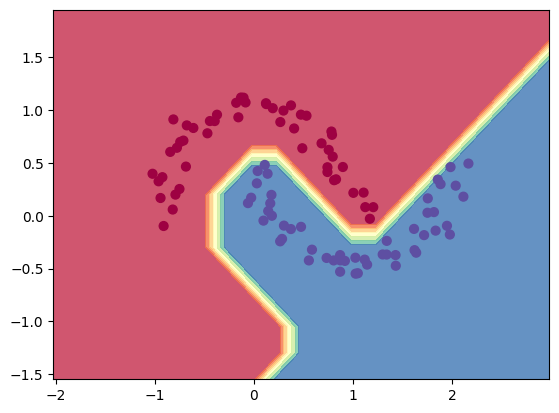

In [8]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
